# LAB4
## MohammadParsa Dini 400101204

In [ ]:
Name = "MohammadParsa Dini"
StudentId = "400101204"

### Importing Required Libraries 

In [1]:
import torch

if torch.cuda.is_available():
    torch.device = 'cuda'
    print('running on gpu')
else:    
    torch.device = 'cpu'
    print('running on cpu')

running on gpu


In [3]:
import os
import cv2
import numpy as np 
import matplotlib.pyplot as plt 

from sklearn import svm
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import cross_val_score


## Part 1:

We read images of four sentiments: neutral, surprise, happy, and disgust. Each category is associated with a label $y$
. We load grayscale images from each folder, flatten them, and associate them with their respective labels based on the folder name. The data is then combined into a larger dataset and shuffled to ensure randomness.

Next, we split the dataset into training and testing sets. We train an SVM model with a linear kernel using the training data. After training, we predict the labels for the test set and evaluate the model's performance using classification metrics, including precision, recall, and F1-score for each class

In [8]:
import os
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

path = "C:/Users/USER/Downloads/Cohn-Kanade/images"

def load_dataset(path):
    images = []
    labels = []
    label_map = {'neutral': 0, 'surprise': 1, 'happy': 2, 'disgust': 3}
    for foldername in os.listdir(path):
        folder_path = os.path.join(path, foldername)
        if os.path.isdir(folder_path) and foldername in label_map:
            for filename in os.listdir(folder_path):
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
                if img is not None:
                    images.append(img.flatten())
                    labels.append(label_map[foldername])
    return np.array(images), np.array(labels)

images, labels = load_dataset(path)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Train the SVM model with a linear kernel
svm = SVC(kernel='linear', C=1)
svm.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['neutral', 'surprise', 'happy', 'disgust']))


              precision    recall  f1-score   support

     neutral       0.75      0.94      0.83        32
    surprise       1.00      0.89      0.94        18
       happy       0.83      0.88      0.86        17
     disgust       0.75      0.40      0.52        15

    accuracy                           0.82        82
   macro avg       0.83      0.78      0.79        82
weighted avg       0.82      0.82      0.80        82



We read images of four sentiments: happy, surprise, neutral, and disgust. Each category is associated with a label 
. We load a specified number of grayscale images for each sentiment, flatten them, and associate them with their respective labels. The data is then combined into a larger dataset and shuffled to ensure randomness.

Next, we split the dataset into training and testing sets. We apply PCA for dimensionality reduction, reducing the feature space to 80 dimensions. We then use cross-validation to find the optimal value of the SVM parameter 
𝐶
 with a linear kernel. The best parameter value is used to train the final SVM model on the training data. The trained model is evaluated on the test set, with metrics such as confusion matrix, precision, recall, and accuracy being calculated.

In [9]:
import os
import numpy as np
import cv2
import itertools
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.decomposition import PCA

# Function to load images and labels
def load_images_from_folder(folder, label, max_images):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
        if img is not None:
            images.append((img.flatten(), label))
        if len(images) >= max_images:
            break
    return images

# Set parameters for number of trained elemnets of each dataset
num_happy = 120
num_surprise = 60
num_neutral = 60
num_disgust = 30

# Load images from respective folders
happy_images = load_images_from_folder('Cohn-Kanade/images/happy', 0, num_happy)  # Label 0
surprise_images = load_images_from_folder('Cohn-Kanade/images/surprise', 1, num_surprise)  # Label 1
neutral_images = load_images_from_folder('Cohn-Kanade/images/neutral', 2, num_neutral)  # Label 2
disgust_images = load_images_from_folder('Cohn-Kanade/images/disgust', 3, num_disgust)  # Label 3

# Combine and shuffle the dataset
dataset = happy_images + surprise_images + neutral_images + disgust_images
np.random.shuffle(dataset)

# Separate features and labels
X = np.array([img[0] for img in dataset])
y = np.array([img[1] for img in dataset])

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# PCA for dimensionality reduction
pca = PCA(n_components=80)  # Reduce to 80 dimensions
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Cross-validation for parameter C
def cross_validate_svm(X, y, C_values, num_folds=5):
    fold_size = len(X) // num_folds
    best_C = None
    best_accuracy = 0

    for C in C_values:
        accuracies = []
        for i in range(num_folds):
            val_indices = range(i * fold_size, (i + 1) * fold_size)
            train_indices = list(set(range(len(X))) - set(val_indices))

            X_train_cv = X[train_indices]
            y_train_cv = y[train_indices]
            X_val_cv = X[val_indices]
            y_val_cv = y[val_indices]

            model = SVC(C=C, kernel='linear', decision_function_shape='ovr')
            model.fit(X_train_cv, y_train_cv)
            y_pred = model.predict(X_val_cv)

            accuracies.append(accuracy_score(y_val_cv, y_pred))
        
        avg_accuracy = np.mean(accuracies)
        print(f"C={C}, Accuracy={avg_accuracy:.7f}")

        if avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            best_C = C
    
    return best_C

# Define range of C values for cross-validation    ---- for gridsearch
C_values = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

# Find the best C value using cross-validation
best_C = cross_validate_svm(X_train_pca, y_train, C_values)
print(f"Best C from cross-validation: {best_C}")

# Train final model with the best C
final_model = SVC(C=best_C, kernel='linear', decision_function_shape='ovr')
final_model.fit(X_train_pca, y_train)

# Make predictions on the test set
y_pred = final_model.predict(X_test_pca)

C=1e-09, Accuracy=0.6054054
C=1e-08, Accuracy=0.8054054
C=1e-07, Accuracy=0.8648649
C=1e-06, Accuracy=0.8594595
C=1e-05, Accuracy=0.8594595
C=0.0001, Accuracy=0.8594595
C=0.001, Accuracy=0.8594595
C=0.01, Accuracy=0.8594595
C=0.1, Accuracy=0.8594595
C=1, Accuracy=0.8594595
C=10, Accuracy=0.8594595
C=100, Accuracy=0.8594595
Best C from cross-validation: 1e-07


In [6]:
# Calculate confusion matrix and metrics
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

# Print results
print("------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("------------------------------------------")
print(f"Accuracy:     {accuracy}")
print(f"Precision:    {precision}")
print(f"Recall:       {recall}")
print("------------------------------------------")

------------------------------------------
Confusion Matrix:
[[17  0  0  0]
 [ 1 11  0  0]
 [ 0  0 12  0]
 [ 1  0  1  4]]
------------------------------------------
Accuracy:     0.9361702127659575
Precision:    0.9422861572917562
Recall:       0.9361702127659575
------------------------------------------


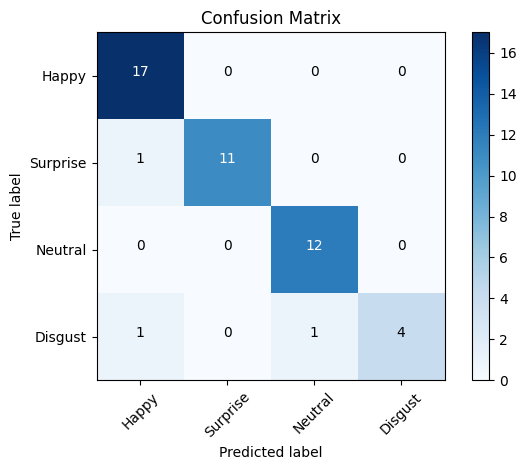

In [7]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Plot the confusion matrix
class_names = ['Happy', 'Surprise', 'Neutral', 'Disgust']
plot_confusion_matrix(conf_matrix, class_names)
plt.show()

## Part 2:

We read four sentiment categories: happy, surprise, neutral, and disgust. Each category is associated with a label 
$y \in \{0,1,2,3\}$
. We load a specified number of grayscale images for each sentiment and flatten them. The data is then combined into a larger dataset and shuffled to create an unorganized set. This dataset consists of images 
$x$
 and their corresponding labels 
$y$.

Next, we split the dataset into training and testing sets, then apply PCA for dimensionality reduction. Using GridSearchCV, we perform cross-validation to find the optimal values for the SVM parameters 
$C$
 and 
$\gamma$
 with the RBF kernel. We train the SVM model using the best parameters and evaluate its performance on the test set, comparing the results with an SVM using a linear kernel.

Best parameters: {'C': 100, 'gamma': 1e-09, 'kernel': 'rbf'}
Confusion Matrix:
[[17  0  0  0]
 [ 1 10  1  0]
 [ 0  0 12  0]
 [ 1  0  2  3]]
Accuracy: 0.8936170212765957
Precision: 0.910862262038074
Recall: 0.8936170212765957


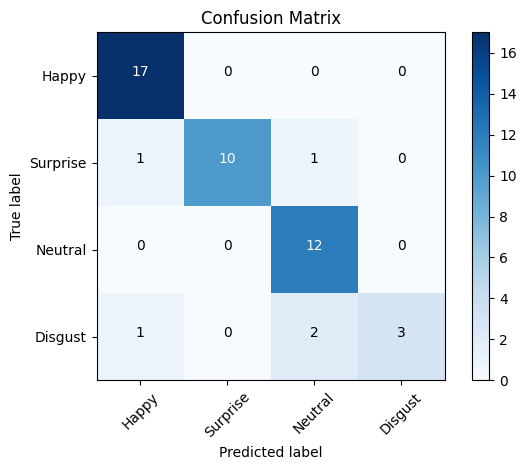

Best C for linear 100
Results for SVM with linear kernel:
Confusion Matrix:
[[17  0  0  0]
 [ 1 11  0  0]
 [ 1  0 11  0]
 [ 0  0  3  3]]
Accuracy: 0.8936170212765957
Precision: 0.9072148456247001
Recall: 0.8936170212765957


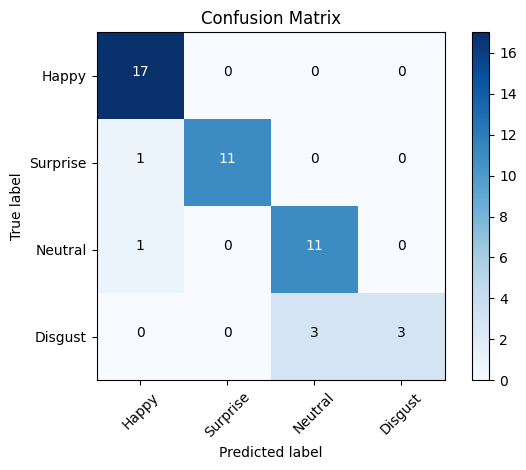

In [2]:
import os
import numpy as np
import cv2
import itertools
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.decomposition import PCA

# Function to load images and labels
def load_images_from_folder(folder, label, max_images):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
        if img is not None:
            images.append((img.flatten(), label))
        if len(images) >= max_images:
            break
    return images

# Set parameters for dataset
num_happy = 120
num_surprise = 60
num_neutral = 60
num_disgust = 30

# Load images from respective folders
happy_images = load_images_from_folder('Cohn-Kanade/images/happy', 0, num_happy)  # Label 0
surprise_images = load_images_from_folder('Cohn-Kanade/images/surprise', 1, num_surprise)  # Label 1
neutral_images = load_images_from_folder('Cohn-Kanade/images/neutral', 2, num_neutral)  # Label 2
disgust_images = load_images_from_folder('Cohn-Kanade/images/disgust', 3, num_disgust)  # Label 3

# Combine and shuffle the dataset
dataset = happy_images + surprise_images + neutral_images + disgust_images
np.random.shuffle(dataset)

# Separate features and labels
X = np.array([img[0] for img in dataset])
y = np.array([img[1] for img in dataset])

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# PCA for dimensionality reduction
pca = PCA(n_components=80)  # Reduce to 80 dimensions
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Define parameter grid for GridSearchCV
param_grid = {
    'C': [10 ** i for i in range(-9, 3)],  # Simplified range of C values
    'gamma': [10 ** i for i in range(-9, 3)],  # Simplified range of gamma values
    'kernel': ['rbf']
}

# Initialize GridSearchCV with SVC and the parameter grid
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the final model with the best parameters
svm_rbf = SVC(**best_params)
svm_rbf.fit(X_train_pca, y_train)

# Make predictions on the test set
y_pred = svm_rbf.predict(X_test_pca)

# Calculate confusion matrix and metrics
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

# Print results
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# ---------------------------------------------------------------------


# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Plot the confusion matrix
class_names = ['Happy', 'Surprise', 'Neutral', 'Disgust']
plot_confusion_matrix(conf_matrix, class_names)
plt.show()

# Train and evaluate SVM with linear kernel for comparison
svm_linear = SVC(kernel='linear', C=best_params['C'])
svm_linear.fit(X_train_pca, y_train)
y_pred_linear = svm_linear.predict(X_test_pca)

# Calculate confusion matrix and metrics for linear SVM
conf_matrix_linear = confusion_matrix(y_test, y_pred_linear)
precision_linear = precision_score(y_test, y_pred_linear, average='weighted')
recall_linear = recall_score(y_test, y_pred_linear, average='weighted')
accuracy_linear = accuracy_score(y_test, y_pred_linear)

# Print results for linear SVM
print(f"Best C for linear {best_params['C']}")
print("Results for SVM with linear kernel:")
print(f"Confusion Matrix:\n{conf_matrix_linear}")
print(f"Accuracy: {accuracy_linear}")
print(f"Precision: {precision_linear}")
print(f"Recall: {recall_linear}")

# Plot the confusion matrix for linear SVM
plot_confusion_matrix(conf_matrix_linear, class_names)
plt.show()


In [8]:
def cross_validate_svm_modified(X, y, C_values, num_folds=5):
    fold_size = len(X) // num_folds
    best_C = None
    best_accuracy = 0
    accuracies__ =[]

    for C in C_values:
        accuracies = []
        for i in range(num_folds):
            val_indices = range(i * fold_size, (i + 1) * fold_size)
            train_indices = list(set(range(len(X))) - set(val_indices))

            X_train_cv = X[train_indices]
            y_train_cv = y[train_indices]
            X_val_cv = X[val_indices]
            y_val_cv = y[val_indices]

            model = SVC(C=C, kernel='linear', decision_function_shape='ovr')
            model.fit(X_train_cv, y_train_cv)
            y_pred = model.predict(X_val_cv)

            accuracies.append(accuracy_score(y_val_cv, y_pred))
        
        avg_accuracy = np.mean(accuracies)
        accuracies__.append(avg_accuracy)
        print(f"C={C}, Accuracy={avg_accuracy:.7f}")

        if avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            best_C = C
    
    return C_values, accuracies__, best_C, best_accuracy

C=1e-09, Accuracy=0.6054054
C=1e-08, Accuracy=0.8108108
C=1e-07, Accuracy=0.8756757
C=1e-06, Accuracy=0.8810811
C=1e-05, Accuracy=0.8810811
C=0.0001, Accuracy=0.8810811
C=0.001, Accuracy=0.8810811
C=0.01, Accuracy=0.8810811
C=0.1, Accuracy=0.8810811
C=1, Accuracy=0.8810811
C=10.0, Accuracy=0.8810811
C=100.0, Accuracy=0.8810811
Best C from cross-validation: 1e-06


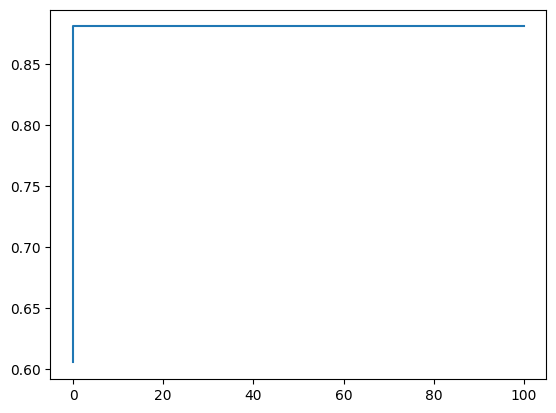

In [9]:

# Define range of C values for cross-validation    ---- for gridsearch
C_values = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]

# Find the best C value using cross-validation
C_vals, accs, best_C, best_acc = cross_validate_svm_modified(X_train_pca, y_train, C_values)
print(f"Best C from cross-validation: {best_C}")

plt.plot(C_vals, accs)

As you see, the model converged so quickly for $C$ values, the best value however, is $1e-6$. This coinvergence was due to the use of too many eigenvalue components in reconstruction of the data. We got 90% accuracy for both of the models with RBF and linear kernel. However, in the process of training, I observed that the linear kernel outperformed the rbf kernel, since the data is well-liearly-separable and applying an rbf kernel would not get us a better result. 